In [22]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import yaml
import scipy
from scipy.ndimage import distance_transform_edt as edt
from PIL import Image
import os

In [ ]:
MAP_NAME = "17_2_"
TRACK_WIDTH_MARGIN = 0.0 # Extra Safety margin, in meters

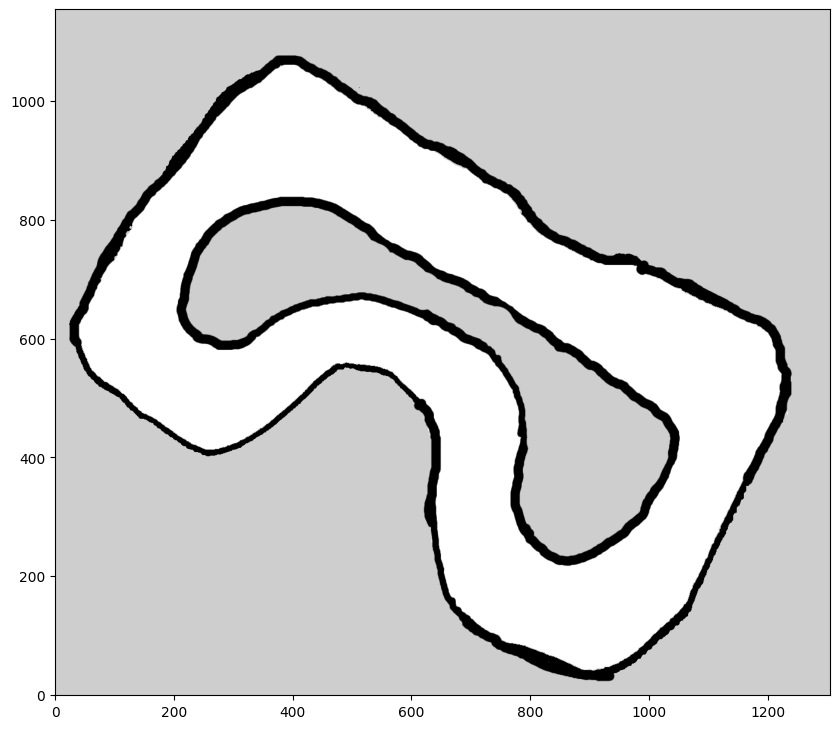

In [ ]:
if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

plt.figure(figsize=(10, 10))
plt.imshow(raw_map_img, cmap='gray', origin='lower')

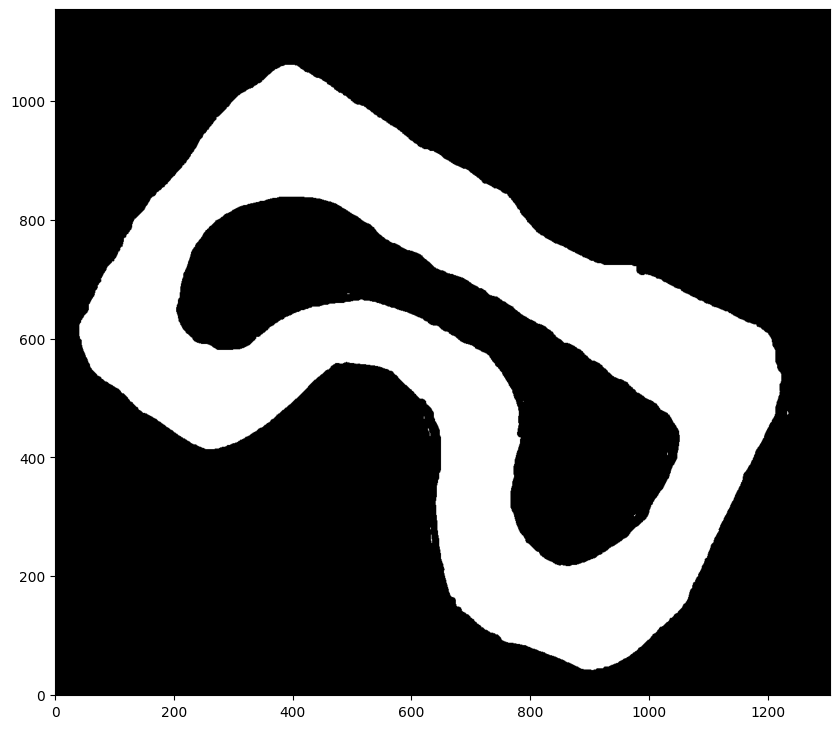

In [25]:
# grayscale -> binary. Converts grey to black
map_img = raw_map_img.copy()
map_img[map_img <= 210.] = 0
map_img[map_img > 210.] = 1

map_height = map_img.shape[0]
# map_width = map_img.shape[1]
map_img
plt.figure(figsize=(10, 10))
plt.imshow(map_img, cmap='gray', origin='lower')

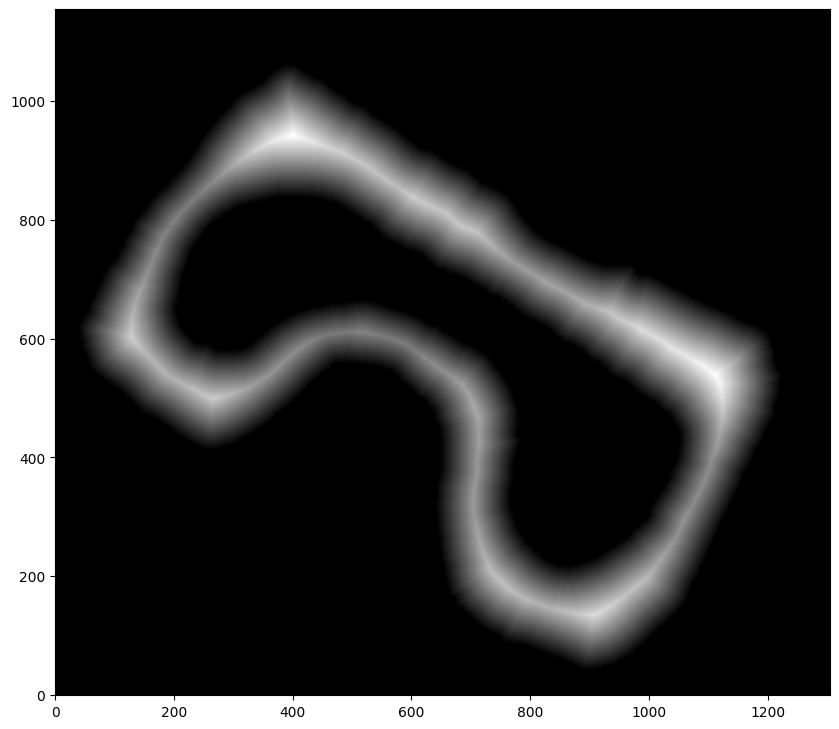

In [26]:
plt.figure(figsize=(10, 10))
# Calculate Euclidean Distance Transform (tells us distance to nearest wall)
dist_transform = scipy.ndimage.distance_transform_edt(map_img)
plt.imshow(dist_transform, cmap='gray', origin='lower')

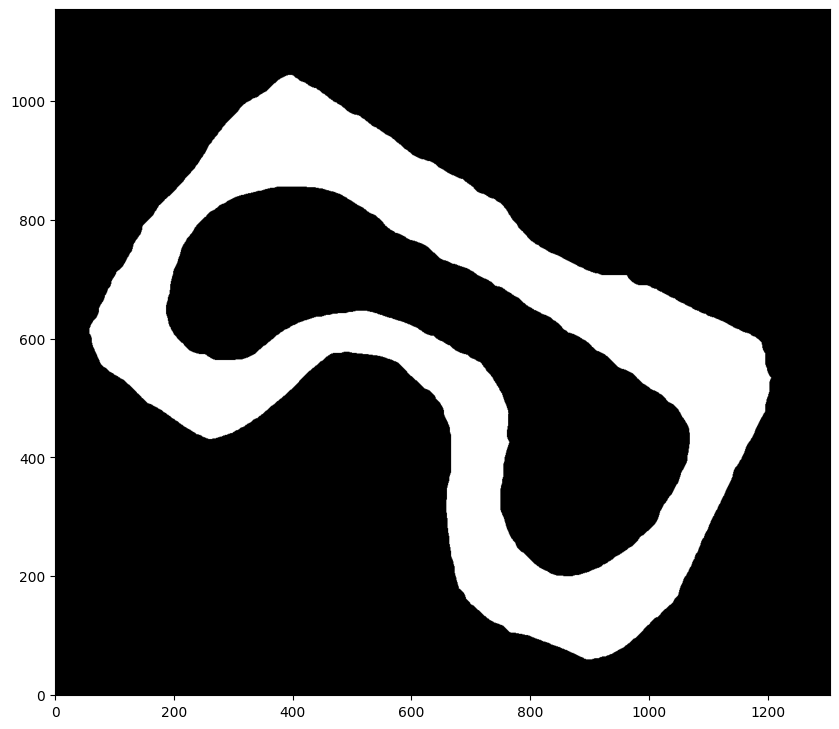

In [27]:

# Threshold the distance transform to create a binary image
THRESHOLD = 0.17 # You should play around with this number. Is you say hairy lines generated, either clean the map so it is more curvy or increase this number
centers = dist_transform > THRESHOLD*dist_transform.max()
plt.figure(figsize=(10, 10))
plt.imshow(centers, origin='lower', cmap='gray')

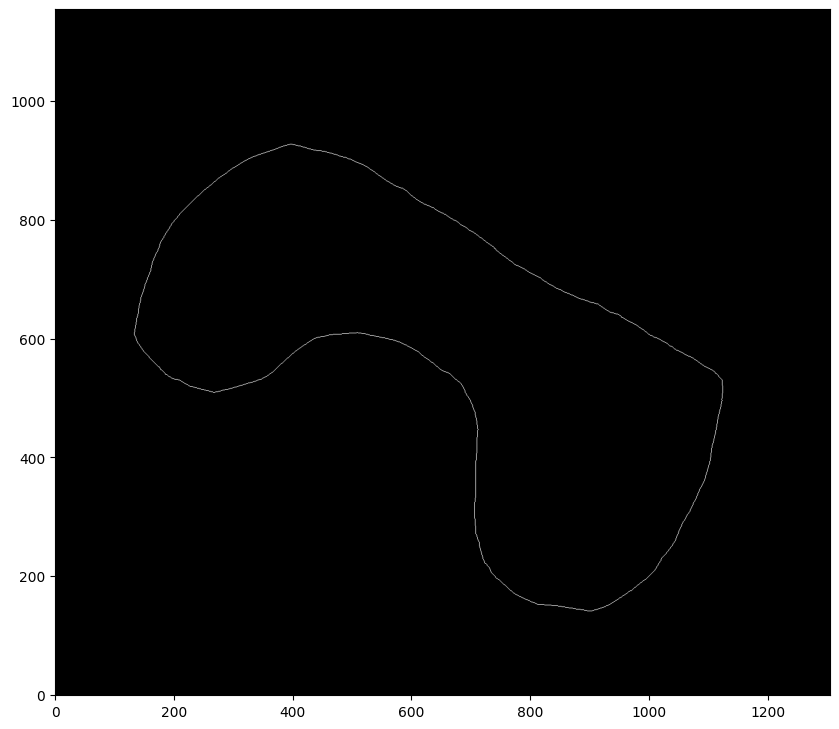

In [28]:
plt.figure(figsize=(10, 10))
centerline = skeletonize(centers)
plt.imshow(centerline, origin='lower', cmap='gray')

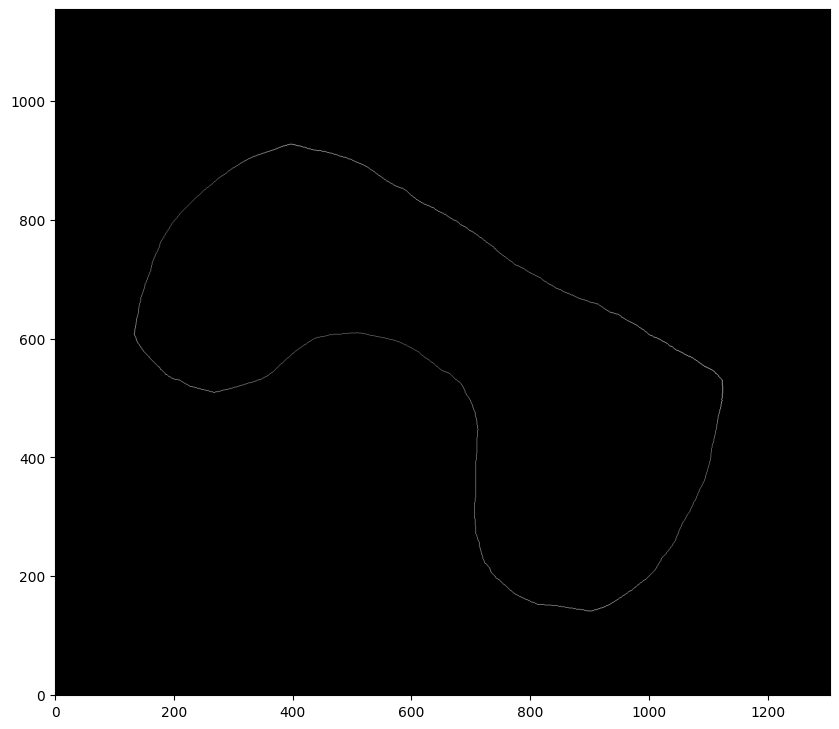

In [29]:
# The centerline has the track width encoded
plt.figure(figsize=(10, 10))
centerline_dist = np.where(centerline, dist_transform, 0)
plt.imshow(centerline_dist, origin='lower', cmap='gray')

In [ ]:
# just done this by guss randomly as it works.
LEFT_START_Y = map_height // 2 - 120

In [31]:
NON_EDGE = 0.0
# Use DFS to extract the outer edge
left_start_y = LEFT_START_Y
left_start_x = 0
while (centerline_dist[left_start_y][left_start_x] == NON_EDGE): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x} {left_start_y}")

Starting position for left edge: 710 457


In [ ]:
# use this if the above code gives some indextation error.
'''
# LEFT_START_Y = map_height // 2 - 120
print (centerline_dist.shape)
LEFT_START_Y = map_height // 2
# print(centerline_dist[int (LEFT_START_Y / 2)][int (329-1 / 2)])

NON_EDGE = 0.0
# Use DFS to extract the outer edge
left_start_y = LEFT_START_Y
x_row = centerline_dist[:, left_start_y]
left_start_x = np.where(x_row != 0)[0][0]

print(left_start_x)
while (centerline_dist[left_start_y][left_start_x] == NON_EDGE): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x} {left_start_y}")
'''

In [ ]:
import sys
sys.setrecursionlimit(20000)

visited = {}
centerline_points = []
track_widths = []
# DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
# If you want the other direction first
DIRECTIONS = [(0, -1), (-1, 0),  (0, 1), (1, 0), (-1, 1), (-1, -1), (1, 1), (1, -1) ]

starting_point = (left_start_x, left_start_y)

def dfs(point):
	if (point in visited): return
	visited[point] = True
	centerline_points.append(np.array(point))
	track_widths.append(np.array([centerline_dist[point[1]][point[0]], centerline_dist[point[1]][point[0]]]))

	for direction in DIRECTIONS:
		if (centerline_dist[point[1] + direction[1]][point[0] + direction[0]] != NON_EDGE and (point[0] + direction[0], point[1] + direction[1]) not in visited):
			dfs((point[0] + direction[0], point[1] + direction[1]))

dfs(starting_point)

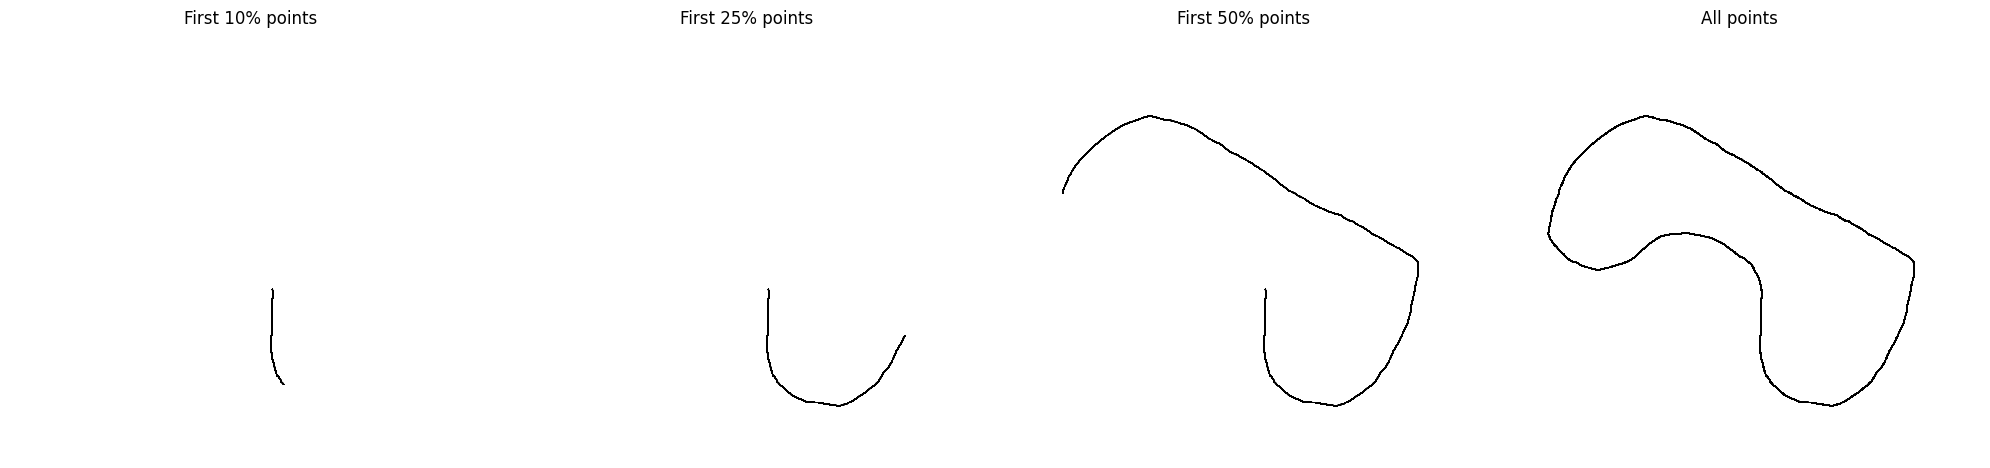

In [33]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:len(centerline_points)//10]:
	centerline_img[y][x] = 255
ax1.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax1.set_title("First 10% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:len(centerline_points)//4]:
	centerline_img[y][x] = 255
ax2.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax2.set_title("First 25% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:int(len(centerline_points)/1.4)]:
	centerline_img[y][x] = 255
ax3.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax3.set_title("First 50% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points:
	centerline_img[y][x] = 1000
ax4.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax4.set_title("All points")
fig.tight_layout()

# Conversion
Convert into Pandas, and go from pixels to meters, and then shift by the origin.

In [34]:
track_widths

[array([63.95310782, 63.95310782]),
 array([63.78871374, 63.78871374]),
 array([63.63961031, 63.63961031]),
 array([64.49806199, 64.49806199]),
 array([64.38167441, 64.38167441]),
 array([64.28063472, 64.28063472]),
 array([64.19501538, 64.19501538]),
 array([64.03124237, 64.03124237]),
 array([63.78871374, 63.78871374]),
 array([63.56099433, 63.56099433]),
 array([64.32728814, 64.32728814]),
 array([64.13267498, 64.13267498]),
 array([62.96824597, 62.96824597]),
 array([62.80127387, 62.80127387]),
 array([62.64982043, 62.64982043]),
 array([62.51399843, 62.51399843]),
 array([62.39390996, 62.39390996]),
 array([62.28964601, 62.28964601]),
 array([62.20128616, 62.20128616]),
 array([62.12889827, 62.12889827]),
 array([62.07253821, 62.07253821]),
 array([62.03224968, 62.03224968]),
 array([62.00806399, 62.00806399]),
 array([62., 62.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61., 61.]),
 array([61.,

In [35]:
track_widths_np = np.array(track_widths)
waypoints = np.array(centerline_points)
print(f"Track widths shape: {track_widths_np.shape}, waypoints shape: {waypoints.shape}")

Track widths shape: (2604, 2), waypoints shape: (2604, 2)


In [36]:
# Merge track with waypoints
data = np.concatenate((waypoints, track_widths_np), axis=1)
data.shape

(2604, 4)

In [37]:
# load map yaml
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = data
transformed_data *= map_resolution
transformed_data += np.array([orig_x, orig_y, 0, 0])

# Safety margin
transformed_data -= np.array([0, 0, TRACK_WIDTH_MARGIN, TRACK_WIDTH_MARGIN])

In [38]:
# Uncomment this if you get the following error: raise IOError("At least two spline normals are crossed, check input or increase smoothing factor!")
# transformed_data = transformed_data[::4]

In [39]:
with open(f"inputs/tracks/{MAP_NAME}.csv", 'wb') as fh:
    np.savetxt(fh, transformed_data, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')